# Sea Surface Current Prediction using LSTM

This notebook outlines the process of loading, inspecting, and preprocessing sea surface current data (`u` and `v` components) for training an LSTM model. The goal is to predict sea surface currents for the next 24 hours based on historical data.

### Import Libraries

In [30]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches
import matplotlib.path as mpath
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, InputLayer, Dropout
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError, MeanAbsoluteError
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.models import load_model

### Load and Inspect Data

The initial step involves loading the dataset using xarray, which facilitates working with multi-dimensional arrays, and inspecting its structure to understand the available dimensions, coordinates, and variables.

In [2]:
# Load the dataset
netcdf_file_path = "Data/24_months_SSC_Data.nc"

# Open the data
dataset = xr.open_dataset(netcdf_file_path)

# Print head of dataset
dataset.head()

<xarray.Dataset>
Dimensions:  (time: 5, lat: 5, lon: 5)
Coordinates:
  * time     (time) datetime64[ns] 2021-01-01 ... 2021-01-01T04:00:00
  * lat      (lat) float32 35.74 35.77 35.79 35.81 35.83
  * lon      (lon) float32 13.68 13.72 13.76 13.8 13.84
Data variables:
    u        (time, lat, lon) float64 ...
    v        (time, lat, lon) float64 ...
    stdu     (time, lat, lon) float64 ...
    stdv     (time, lat, lon) float64 ...
    cov      (time, lat, lon) float64 ...
    velo     (time, lat, lon) float64 ...
    head     (time, lat, lon) float64 ...
Attributes: (12/17)
    NC_GLOBAL.Title:                   Near-Real time Surface Ocean Velocity
    NC_GLOBAL.origin:                  BARK (measured);POZZ (measured);
    NC_GLOBAL.source:                  HF Radar Derived Surface Currents obta...
    NC_GLOBAL.history:                 08-Jun-2023 14:45:58
    NC_GLOBAL.grid_type:               REGULAR
    NC_GLOBAL.Conventions:             CF-1.4
    ...                                ...
    NC_GLOBAL.grid_resolution:         3.0km
    NC_GLOBAL.geospatial_lat_max:      36.8802
    NC_GLOBAL.geospatial_lat_min:      35.7447
    NC_GLOBAL.geospatial_lon_max:      15.3804
    NC_GLOBAL.geospatial_lon_min:      13.6768
    NC_GLOBAL.netcdf_library_version:  v2

### Convert the dataset to a pandas DataFrame

In [3]:
# Convert the dataset to a pandas DataFrame
df = dataset.to_dataframe().reset_index()

# Drop columns from the DataFrame
df = df.drop(columns=['stdu', 'stdv', 'cov', 'velo', 'head'])

# Remove rows where 'u' has NaN values
df = df.dropna(subset=['u'])
df = df.dropna(subset=['v'])

df.index = pd.to_datetime(df['time'], format='%d-%m-%Y %H:%M:%S')

df

,time,lat,lon,u,v
time,,,,,
2021-01-01 00:00:00,2021-01-01 00:00:00,36.011902,14.6908,-0.187088,-0.048105
2021-01-01 00:00:00,2021-01-01 00:00:00,36.011902,14.7314,-0.250971,-0.024680
2021-01-01 00:00:00,2021-01-01 00:00:00,36.034100,14.5286,0.079402,0.039575
2021-01-01 00:00:00,2021-01-01 00:00:00,36.034100,14.5692,-0.229349,0.057154
2021-01-01 00:00:00,2021-01-01 00:00:00,36.034100,14.6908,-0.394889,0.063383
...,...,...,...,...,...
2022-12-31 23:00:00,2022-12-31 23:00:00,36.880199,14.1230,0.327331,-0.174509
2022-12-31 23:00:00,2022-12-31 23:00:00,36.880199,14.1635,0.400850,-0.164626
2022-12-31 23:00:00,2022-12-31 23:00:00,36.880199,14.2041,0.460808,-0.139945


### Geospatial Visualization
Define boundaries and coordinates for visualization

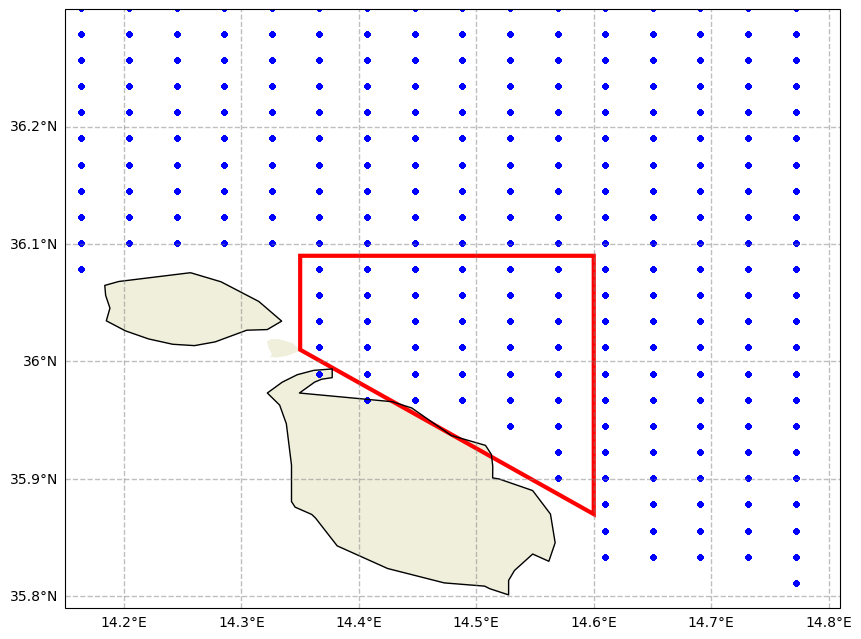

In [4]:
# Define the boundaries for map
boundaries = {
    'min_lon': 14.15,  
    'max_lon': 14.81,  
    'min_lat': 35.79,  
    'max_lat': 36.3   
}

# Define the coordinates 
polygon_coordinates = [
    (14.6, 35.87), 
    (14.35, 36.01), 
    (14.35, 36.09), 
    (14.6, 36.09), 
    (14.6, 35.87)
]

# Create a plot with Cartopy
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([boundaries['min_lon'], boundaries['max_lon'], boundaries['min_lat'], boundaries['max_lat']], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plotting all points within the boundary from the dataframe 'df'
ax.scatter(df['lon'], df['lat'], s=10, color='blue', marker='o', alpha=0.5, transform=ccrs.Geodetic())

# Create a red polygon and add it to the plot
red_polygon = mpatches.Polygon(polygon_coordinates, closed=True, edgecolor='red', facecolor='none', linewidth=3, transform=ccrs.Geodetic())
ax.add_patch(red_polygon)

# Gridlines and labels
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

plt.show()

### Data Filtering 
Filter the DataFrame to include only data points within the specified polygon.

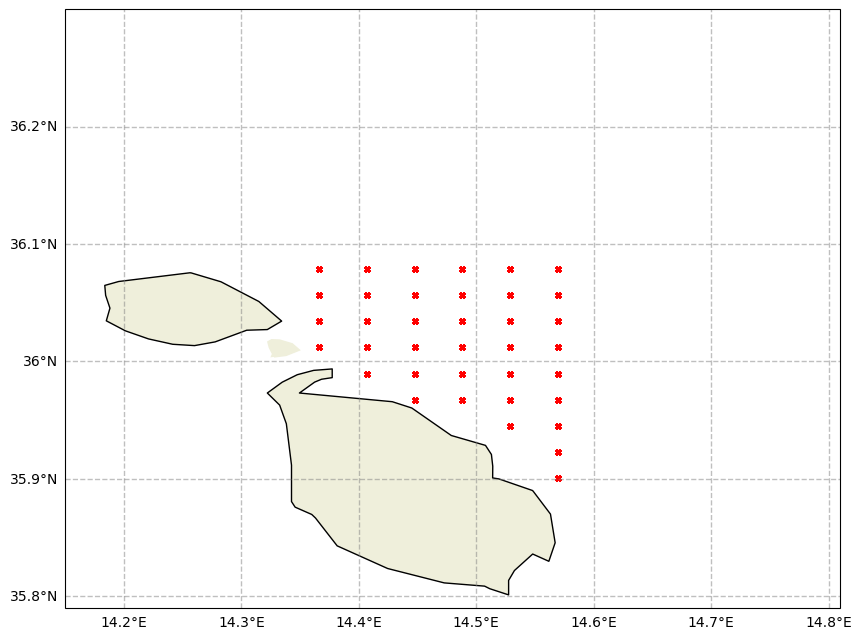

In [5]:
# Convert the polygon coordinates to a Path object
polygon_path = mpath.Path(polygon_coordinates)

# Use the Path object to find points inside the polygon
inside_polygon = df.apply(lambda row: polygon_path.contains_point((row['lon'], row['lat'])), axis=1)
df_inside_polygon = df[inside_polygon]

# Create a plot with Cartopy
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([boundaries['min_lon'], boundaries['max_lon'], boundaries['min_lat'], boundaries['max_lat']], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plotting only the points within the polygon
ax.scatter(df_inside_polygon['lon'], df_inside_polygon['lat'], s=10, color='red', marker='x', alpha=0.5, transform=ccrs.Geodetic())

# Gridlines and labels
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

plt.show()

### Data Preparation

In [6]:
# Convert the polygon coordinates to a Path object
polygon_path = mpath.Path(polygon_coordinates)

# Prepare the coordinates as a list of tuples
coordinates = list(zip(df['lon'], df['lat']))

# Check if each coordinate is inside the polygon
inside_mask = [polygon_path.contains_point(coord) for coord in coordinates]

# Filter the DataFrame for points within the polygon
df_inside_polygon = df[inside_mask]

# Removing potential duplicates
df_inside_polygon = df_inside_polygon.drop_duplicates(subset=['lon', 'lat'])

# Count the number of points inside the polygon
num_points_inside_polygon = df_inside_polygon.shape[0]
print(f"Total number of points inside the polygon: {num_points_inside_polygon}\n")
print("Coordinates of the points inside the polygon:")

# Print out all of the coordinate pairs
coordinates_inside = df_inside_polygon[['lon', 'lat']].values
for lon, lat in coordinates_inside:
    print(f"({lon}, {lat})")

Total number of points inside the polygon: 37

Coordinates of the points inside the polygon:
(14.528599739074707, 36.03409957885742)
(14.569199562072754, 36.03409957885742)
(14.528599739074707, 36.056400299072266)
(14.569199562072754, 36.056400299072266)
(14.528599739074707, 36.07870101928711)
(14.569199562072754, 36.07870101928711)
(14.447500228881836, 36.07870101928711)
(14.447500228881836, 36.056400299072266)
(14.406900405883789, 36.07870101928711)
(14.528599739074707, 36.01190185546875)
(14.569199562072754, 36.01190185546875)
(14.48799991607666, 36.07870101928711)
(14.48799991607666, 36.03409957885742)
(14.48799991607666, 36.056400299072266)
(14.569199562072754, 35.96730041503906)
(14.569199562072754, 35.989601135253906)
(14.528599739074707, 35.989601135253906)
(14.48799991607666, 36.01190185546875)
(14.447500228881836, 36.03409957885742)
(14.447500228881836, 36.01190185546875)
(14.366399765014648, 36.07870101928711)
(14.447500228881836, 35.989601135253906)
(14.48799991607666, 35.9

In [7]:
# Assuming 'inside_mask' is a list of booleans indicating whether each point is inside the polygon
inside_mask = [polygon_path.contains_point((lon, lat)) for lon, lat in zip(df['lon'], df['lat'])]

# Convert 'inside_mask' to a pandas Series to use as a boolean indexer
inside_series = pd.Series(inside_mask, index=df.index)

# Filter the original DataFrame using the boolean Series
final_df = df[inside_series]

# Display the resulting DataFrame
final_df

,time,lat,lon,u,v
time,,,,,
2021-01-01 00:00:00,2021-01-01 00:00:00,36.034100,14.5286,0.079402,0.039575
2021-01-01 00:00:00,2021-01-01 00:00:00,36.034100,14.5692,-0.229349,0.057154
2021-01-01 00:00:00,2021-01-01 00:00:00,36.056400,14.5286,0.046379,0.059340
2021-01-01 00:00:00,2021-01-01 00:00:00,36.056400,14.5692,-0.235254,0.081921
2021-01-01 00:00:00,2021-01-01 00:00:00,36.078701,14.5286,0.023732,0.085635
...,...,...,...,...,...
2022-12-31 23:00:00,2022-12-31 23:00:00,36.078701,14.4069,-0.147110,-0.092706
2022-12-31 23:00:00,2022-12-31 23:00:00,36.078701,14.4475,-0.092843,-0.124476
2022-12-31 23:00:00,2022-12-31 23:00:00,36.078701,14.4880,-0.047441,-0.130120


### Exctract data only for a single pair of coordinates

In [8]:
# Coordinates 
target_lat = 36.03409957885742
target_lon = 14.528599739074707

# Filter the DataFrame for the exact coordinates
df_point = final_df[(final_df['lat'] == target_lat) & (final_df['lon'] == target_lon)]

# Display the filtered DataFrame
df_point

,time,lat,lon,u,v
time,,,,,
2021-01-01 00:00:00,2021-01-01 00:00:00,36.0341,14.5286,0.079402,0.039575
2021-01-01 13:00:00,2021-01-01 13:00:00,36.0341,14.5286,0.162881,-0.039021
2021-01-01 14:00:00,2021-01-01 14:00:00,36.0341,14.5286,0.144165,-0.023481
2021-01-01 15:00:00,2021-01-01 15:00:00,36.0341,14.5286,0.280085,-0.033406
2021-01-01 16:00:00,2021-01-01 16:00:00,36.0341,14.5286,0.115884,-0.089223
...,...,...,...,...,...
2022-12-31 19:00:00,2022-12-31 19:00:00,36.0341,14.5286,0.003522,-0.170710
2022-12-31 20:00:00,2022-12-31 20:00:00,36.0341,14.5286,0.000774,-0.120463
2022-12-31 21:00:00,2022-12-31 21:00:00,36.0341,14.5286,-0.030468,-0.092138


<Axes: xlabel='time'>

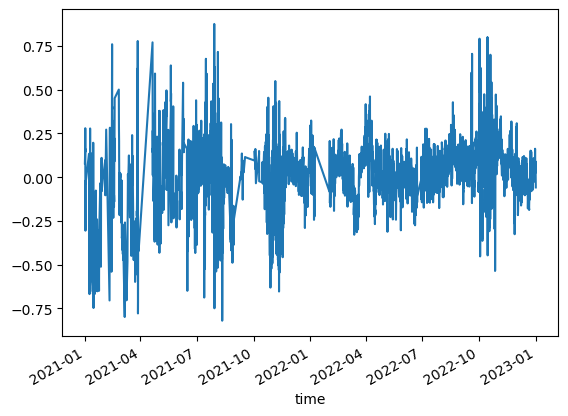

In [9]:
df1_u = df_point['u']
df1_u.plot()

<Axes: xlabel='time'>

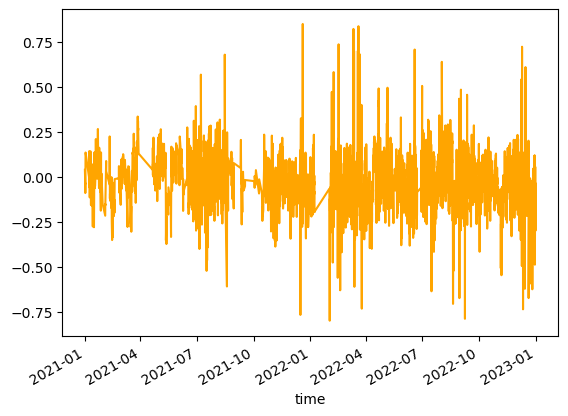

In [10]:
df1_v = df_point['v']
df1_v.plot(color='orange')

### Convert the time series data into a format suitable for LSTM

In [11]:
def df_to_X_y_multivariate(df_u, df_v, window_size=5):
    assert len(df_u) == len(df_v), "The length of both series must be equal."
    
    X, y = [], []
    for i in range(len(df_u) - window_size):
        u_part = df_u[i:i+window_size].to_numpy()
        v_part = df_v[i:i+window_size].to_numpy()
        row = np.stack((u_part, v_part), axis=1)  # Shape will be window_size x 2
        X.append(row)
        
        # Next values for both u and v
        label = np.array([df_u.iloc[i+window_size], df_v.iloc[i+window_size]])
        y.append(label)
    
    return np.array(X), np.array(y)

window_size = 5
X, y = df_to_X_y_multivariate(df_point['u'], df_point['v'], window_size=window_size)

print("Shape of X:", X.shape)  # Expected shape: (num_samples, window_size, 2)
print("Shape of y:", y.shape)  # Expected shape: (num_samples, 2)

Shape of X: (8842, 5, 2)
Shape of y: (8842, 2)


### Split the data

In [12]:
def train_val_test_split(X, y, train_size, val_size, test_size):
    # Calculate the indices for the end of each segment
    total_size = len(X)
    train_end = int(total_size * train_size)
    val_end = train_end + int(total_size * val_size)
    
    # Split the data
    X_train = X[:train_end]
    y_train = y[:train_end]
    
    X_val = X[train_end:val_end]
    y_val = y[train_end:val_end]
    
    X_test = X[val_end:]
    y_test = y[val_end:]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Assuming X and y are defined and have the same order (time-wise)
train_size = 0.70
val_size = 0.15
test_size = 1 - (train_size + val_size)

X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(X, y, train_size, val_size, test_size)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((6189, 5, 2), (6189, 2), (1326, 5, 2), (1326, 2), (1327, 5, 2), (1327, 2))

### Define & Compile the Model

In [31]:
# # Define the model
# model = Sequential()
# model.add(InputLayer((5, 2)))
# model.add(LSTM(128, return_sequences=True))  # More units and return sequences for stacking LSTMs
# model.add(Dropout(0.2))  # Regularization with dropout
# model.add(LSTM(64, return_sequences=True))  # Stacking another LSTM layer
# model.add(Dropout(0.2))  # Regularization with dropout
# model.add(LSTM(32))  # Last LSTM does not return sequences
# model.add(Dropout(0.2))  # Regularization with dropout
# model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))  # Dense layer with L2 regularization
# model.add(Dense(2, activation='linear'))

# model.summary()

# # Define ModelCheckpoint callback to save the best model
# cp = ModelCheckpoint(filepath="Data/LSTM/Saved_Models/lstm_multivar_target_best_model",
#                      save_best_only=True,
#                      monitor='val_loss',  
#                      mode='min',  
#                      verbose=0)   

# # Compile the model
# model.compile(loss=MeanAbsoluteError(),
#               optimizer=Adam(learning_rate=0.0001))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 5, 128)            67072     
                                                                 
 dropout_3 (Dropout)         (None, 5, 128)            0         
                                                                 
 lstm_4 (LSTM)               (None, 5, 64)             49408     
                                                                 
 dropout_4 (Dropout)         (None, 5, 64)             0         
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 16)               

In [35]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, TimeDistributed, BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.optimizers import Adam
from keras.regularizers import l2

model = Sequential()
model.add(InputLayer(input_shape=(5, 2)))

# Adding more LSTM layers and increasing the number of units
model.add(LSTM(256, return_sequences=True))
model.add(BatchNormalization())  # Adding batch normalization
model.add(Dropout(0.3))  # Increased dropout for regularization

model.add(LSTM(128, return_sequences=True))
model.add(BatchNormalization())  # Adding batch normalization
model.add(Dropout(0.3))  # Increased dropout for regularization

# Adding TimeDistributed layers to apply a Dense layer to each time step independently
model.add(TimeDistributed(Dense(64, activation='relu', kernel_regularizer=l2(0.01))))

model.add(LSTM(64, return_sequences=True))
model.add(BatchNormalization())  # Adding batch normalization
model.add(Dropout(0.3))  # Increased dropout for regularization

model.add(LSTM(32))  # Final LSTM layer does not return sequences
model.add(Dropout(0.3))  # Increased dropout for regularization

# Dense layers with L2 regularization
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))

# Output layer for predicting both u and v components
model.add(Dense(2, activation='linear'))

model.summary()

# Define ModelCheckpoint callback to save the best model
cp = ModelCheckpoint(filepath="Data/LSTM/Saved_Models/lstm_multivar_target_complex_best_model",
                     save_best_only=True,
                     monitor='val_loss',  
                     mode='min',  
                     verbose=1)  # Changed verbose to 1 for more detailed output during training

# Compile the model with a smaller learning rate to accommodate the increased complexity
model.compile(loss=MeanSquaredError(),
              optimizer=Adam(learning_rate=0.0001))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 5, 256)            265216    
                                                                 
 batch_normalization (Batch  (None, 5, 256)            1024      
 Normalization)                                                  
                                                                 
 dropout_6 (Dropout)         (None, 5, 256)            0         
                                                                 
 lstm_8 (LSTM)               (None, 5, 128)            197120    
                                                                 
 batch_normalization_1 (Bat  (None, 5, 128)            512       
 chNormalization)                                                
                                                                 
 dropout_7 (Dropout)         (None, 5, 128)           

### Train the Model

In [41]:
# Fit the model with the training data and validate with the validation data
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=20,
                    callbacks=[cp])

Epoch 1/20
192/194 [============================>.] - ETA: 0s - loss: 0.1380
Epoch 1: val_loss improved from 0.13526 to 0.12004, saving model to Data/LSTM/Saved_Models\lstm_multivar_target_complex_best_model
INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_multivar_target_complex_best_model\assets


INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_multivar_target_complex_best_model\assets


194/194 [==============================] - 17s 60ms/step - loss: 0.1379 - val_loss: 0.1200
Epoch 2/20
192/194 [============================>.] - ETA: 0s - loss: 0.1252
Epoch 2: val_loss improved from 0.12004 to 0.10931, saving model to Data/LSTM/Saved_Models\lstm_multivar_target_complex_best_model
INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_multivar_target_complex_best_model\assets


INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_multivar_target_complex_best_model\assets


194/194 [==============================] - 10s 51ms/step - loss: 0.1252 - val_loss: 0.1093
Epoch 3/20
194/194 [==============================] - ETA: 0s - loss: 0.1148
Epoch 3: val_loss improved from 0.10931 to 0.10017, saving model to Data/LSTM/Saved_Models\lstm_multivar_target_complex_best_model
INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_multivar_target_complex_best_model\assets


INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_multivar_target_complex_best_model\assets


194/194 [==============================] - 11s 59ms/step - loss: 0.1148 - val_loss: 0.1002
Epoch 4/20
191/194 [============================>.] - ETA: 0s - loss: 0.1057
Epoch 4: val_loss improved from 0.10017 to 0.09294, saving model to Data/LSTM/Saved_Models\lstm_multivar_target_complex_best_model
INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_multivar_target_complex_best_model\assets


INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_multivar_target_complex_best_model\assets


194/194 [==============================] - 10s 50ms/step - loss: 0.1057 - val_loss: 0.0929
Epoch 5/20
191/194 [============================>.] - ETA: 0s - loss: 0.0982
Epoch 5: val_loss improved from 0.09294 to 0.08537, saving model to Data/LSTM/Saved_Models\lstm_multivar_target_complex_best_model
INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_multivar_target_complex_best_model\assets


INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_multivar_target_complex_best_model\assets


194/194 [==============================] - 10s 51ms/step - loss: 0.0982 - val_loss: 0.0854
Epoch 6/20
193/194 [============================>.] - ETA: 0s - loss: 0.0918
Epoch 6: val_loss improved from 0.08537 to 0.08227, saving model to Data/LSTM/Saved_Models\lstm_multivar_target_complex_best_model
INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_multivar_target_complex_best_model\assets


INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_multivar_target_complex_best_model\assets


194/194 [==============================] - 10s 52ms/step - loss: 0.0919 - val_loss: 0.0823
Epoch 7/20
191/194 [============================>.] - ETA: 0s - loss: 0.0871
Epoch 7: val_loss improved from 0.08227 to 0.07507, saving model to Data/LSTM/Saved_Models\lstm_multivar_target_complex_best_model
INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_multivar_target_complex_best_model\assets


INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_multivar_target_complex_best_model\assets


194/194 [==============================] - 11s 55ms/step - loss: 0.0870 - val_loss: 0.0751
Epoch 8/20
193/194 [============================>.] - ETA: 0s - loss: 0.0835
Epoch 8: val_loss improved from 0.07507 to 0.07264, saving model to Data/LSTM/Saved_Models\lstm_multivar_target_complex_best_model
INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_multivar_target_complex_best_model\assets


INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_multivar_target_complex_best_model\assets


194/194 [==============================] - 11s 59ms/step - loss: 0.0835 - val_loss: 0.0726
Epoch 9/20
191/194 [============================>.] - ETA: 0s - loss: 0.0795
Epoch 9: val_loss improved from 0.07264 to 0.06881, saving model to Data/LSTM/Saved_Models\lstm_multivar_target_complex_best_model
INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_multivar_target_complex_best_model\assets


INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_multivar_target_complex_best_model\assets


194/194 [==============================] - 10s 50ms/step - loss: 0.0796 - val_loss: 0.0688
Epoch 10/20
192/194 [============================>.] - ETA: 0s - loss: 0.0767
Epoch 10: val_loss improved from 0.06881 to 0.06732, saving model to Data/LSTM/Saved_Models\lstm_multivar_target_complex_best_model
INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_multivar_target_complex_best_model\assets


INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_multivar_target_complex_best_model\assets


194/194 [==============================] - 10s 51ms/step - loss: 0.0768 - val_loss: 0.0673
Epoch 11/20
191/194 [============================>.] - ETA: 0s - loss: 0.0740
Epoch 11: val_loss improved from 0.06732 to 0.06298, saving model to Data/LSTM/Saved_Models\lstm_multivar_target_complex_best_model
INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_multivar_target_complex_best_model\assets


INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_multivar_target_complex_best_model\assets


194/194 [==============================] - 10s 51ms/step - loss: 0.0740 - val_loss: 0.0630
Epoch 12/20
191/194 [============================>.] - ETA: 0s - loss: 0.0713
Epoch 12: val_loss improved from 0.06298 to 0.06195, saving model to Data/LSTM/Saved_Models\lstm_multivar_target_complex_best_model
INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_multivar_target_complex_best_model\assets


INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_multivar_target_complex_best_model\assets


194/194 [==============================] - 10s 50ms/step - loss: 0.0713 - val_loss: 0.0620
Epoch 13/20
192/194 [============================>.] - ETA: 0s - loss: 0.0697
Epoch 13: val_loss improved from 0.06195 to 0.05931, saving model to Data/LSTM/Saved_Models\lstm_multivar_target_complex_best_model
INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_multivar_target_complex_best_model\assets


INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_multivar_target_complex_best_model\assets


194/194 [==============================] - 13s 69ms/step - loss: 0.0696 - val_loss: 0.0593
Epoch 14/20
193/194 [============================>.] - ETA: 0s - loss: 0.0682
Epoch 14: val_loss did not improve from 0.05931
194/194 [==============================] - 3s 17ms/step - loss: 0.0683 - val_loss: 0.0595
Epoch 15/20
194/194 [==============================] - ETA: 0s - loss: 0.0665
Epoch 15: val_loss improved from 0.05931 to 0.05754, saving model to Data/LSTM/Saved_Models\lstm_multivar_target_complex_best_model
INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_multivar_target_complex_best_model\assets


INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_multivar_target_complex_best_model\assets


194/194 [==============================] - 10s 53ms/step - loss: 0.0665 - val_loss: 0.0575
Epoch 16/20
190/194 [============================>.] - ETA: 0s - loss: 0.0654
Epoch 16: val_loss improved from 0.05754 to 0.05723, saving model to Data/LSTM/Saved_Models\lstm_multivar_target_complex_best_model
INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_multivar_target_complex_best_model\assets


INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_multivar_target_complex_best_model\assets


194/194 [==============================] - 10s 50ms/step - loss: 0.0654 - val_loss: 0.0572
Epoch 17/20
193/194 [============================>.] - ETA: 0s - loss: 0.0645
Epoch 17: val_loss improved from 0.05723 to 0.05545, saving model to Data/LSTM/Saved_Models\lstm_multivar_target_complex_best_model
INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_multivar_target_complex_best_model\assets


INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_multivar_target_complex_best_model\assets


194/194 [==============================] - 10s 51ms/step - loss: 0.0645 - val_loss: 0.0554
Epoch 18/20
193/194 [============================>.] - ETA: 0s - loss: 0.0641
Epoch 18: val_loss improved from 0.05545 to 0.05492, saving model to Data/LSTM/Saved_Models\lstm_multivar_target_complex_best_model
INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_multivar_target_complex_best_model\assets


INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_multivar_target_complex_best_model\assets


194/194 [==============================] - 11s 55ms/step - loss: 0.0640 - val_loss: 0.0549
Epoch 19/20
191/194 [============================>.] - ETA: 0s - loss: 0.0632
Epoch 19: val_loss improved from 0.05492 to 0.05386, saving model to Data/LSTM/Saved_Models\lstm_multivar_target_complex_best_model
INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_multivar_target_complex_best_model\assets


INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_multivar_target_complex_best_model\assets


194/194 [==============================] - 10s 51ms/step - loss: 0.0632 - val_loss: 0.0539
Epoch 20/20
194/194 [==============================] - ETA: 0s - loss: 0.0623
Epoch 20: val_loss did not improve from 0.05386
194/194 [==============================] - 4s 18ms/step - loss: 0.0623 - val_loss: 0.0541


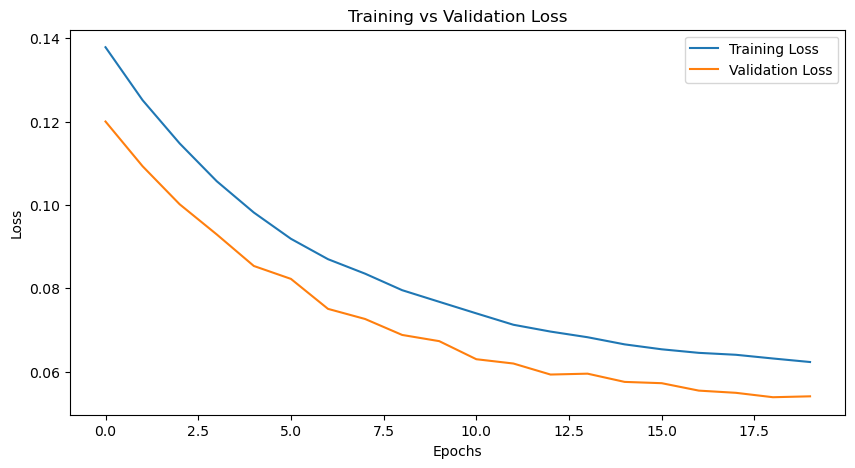

In [46]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Evaluation

In [42]:
model = load_model("Data/LSTM/Saved_Models/lstm_multivar_target_best_model")

In [43]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, median_absolute_error

# Already calculated MSE by using mean_squared_error without the square root
mse_u = mean_squared_error(y_test[:, 0], test_predictions[:, 0])
mse_v = mean_squared_error(y_test[:, 1], test_predictions[:, 1])

# Calculate R-squared for both components
r2_u = r2_score(y_test[:, 0], test_predictions[:, 0])
r2_v = r2_score(y_test[:, 1], test_predictions[:, 1])

# Calculate Explained Variance Score for both components
explained_variance_u = explained_variance_score(y_test[:, 0], test_predictions[:, 0])
explained_variance_v = explained_variance_score(y_test[:, 1], test_predictions[:, 1])

# Calculate Median Absolute Error for both components
median_ae_u = median_absolute_error(y_test[:, 0], test_predictions[:, 0])
median_ae_v = median_absolute_error(y_test[:, 1], test_predictions[:, 1])

# Output the additional error metrics
print("Test MSE for 'u' component:", mse_u)
print("Test MSE for 'v' component:", mse_v)
print("\nTest R-squared for 'u' component:", r2_u)
print("Test R-squared for 'v' component:", r2_v)
print("\nTest Explained Variance for 'u' component:", explained_variance_u)
print("Test Explained Variance for 'v' component:", explained_variance_v)
print("\nTest Median AE for 'u' component:", median_ae_u)
print("Test Median AE for 'v' component:", median_ae_v)

Test MSE for 'u' component: 0.005096581456179583
Test MSE for 'v' component: 0.008410190651699234

Test R-squared for 'u' component: 0.6116402094673898
Test R-squared for 'v' component: 0.42908451274399273

Test Explained Variance for 'u' component: 0.6423702884473865
Test Explained Variance for 'v' component: 0.4427133901340583

Test Median AE for 'u' component: 0.03885033964929871
Test Median AE for 'v' component: 0.04103942271574336


In [44]:
test_results = pd.DataFrame({
    'Test Predictions u': test_predictions[:, 0],
    'Actuals u': y_test[:, 0],
    'Test Predictions v': test_predictions[:, 1],
    'Actuals v': y_test[:, 1]
})

test_results

,Test Predictions u,Actuals u,Test Predictions v,Actuals v
0,-0.011595,0.209414,-0.029270,-0.092145
1,0.039276,0.125163,-0.059651,-0.109734
2,0.080935,0.186031,-0.078790,-0.105508
3,0.111460,0.187845,-0.088259,-0.104333
4,0.117706,0.223268,-0.100166,-0.087487
...,...,...,...,...
1322,0.052561,0.003522,-0.181570,-0.170710
1323,0.047550,0.000774,-0.166690,-0.120463
1324,0.032940,-0.030468,-0.151547,-0.092138
1325,0.011301,-0.026932,-0.127874,-0.137819


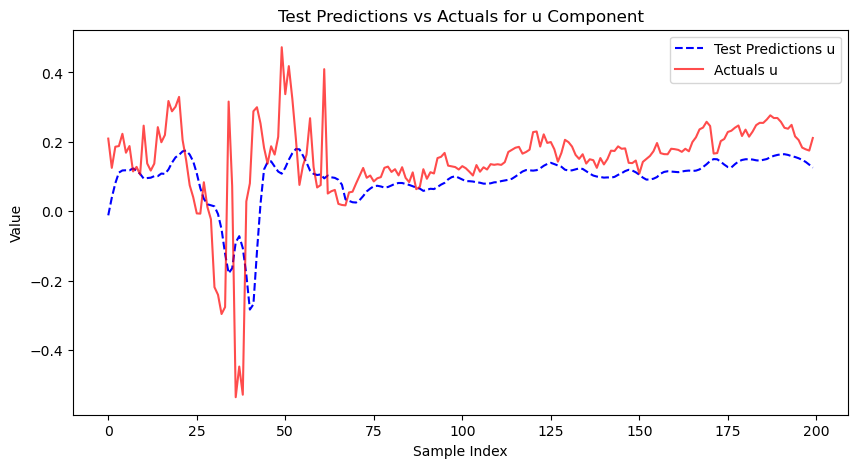

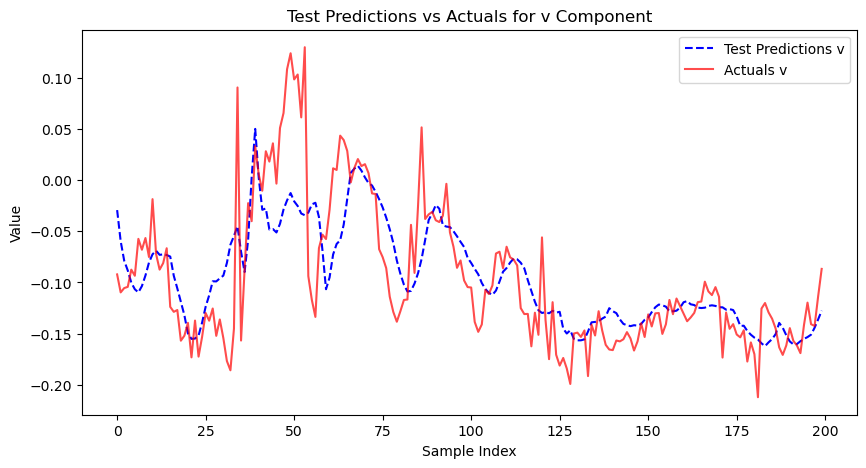

In [45]:
# Plot for the 'u' component test predictions vs actuals
plt.figure(figsize=(10, 5))
plt.plot(test_results.index[:200], test_results['Test Predictions u'][:200], label='Test Predictions u', color='blue', linestyle='--')
plt.plot(test_results.index[:200], test_results['Actuals u'][:200], label='Actuals u', color='red', alpha=0.7)
plt.title('Test Predictions vs Actuals for u Component')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()

# Plot for the 'v' component test predictions vs actuals
plt.figure(figsize=(10, 5))
plt.plot(test_results.index[:200], test_results['Test Predictions v'][:200], label='Test Predictions v', color='blue', linestyle='--')
plt.plot(test_results.index[:200], test_results['Actuals v'][:200], label='Actuals v', color='red', alpha=0.7)
plt.title('Test Predictions vs Actuals for v Component')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()